# Introduction
This notebook is target to train a model to identify if a person is wearing a face mask and a safety helmet.

The dataset is small, with 308 images, and around 1800 detected face.

Target trial as below:
1. Try the basic transfer learning using Resnet-18
- No freezing layer
- Freezing Layer
2. Leverage YOLO-v5 for the attempt on training with custome data

In [1]:
# Import basic library
import os
import cv2
import random
import numpy as np
from lxml import etree
from tqdm import tqdm
from PIL import Image
import cv2 
from scipy import stats

from IPython.display import display

In [2]:
# Import Library for ResNet
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Annotation extraction and image chop

In [3]:
IMAGE_SRC = '../dataset/images'
ANNOTATION_FILE = '../dataset/annotations.xml'

img_list = [f for f in os.listdir(IMAGE_SRC) if os.path.isfile(os.path.join(IMAGE_SRC, f))]
root = etree.parse(ANNOTATION_FILE).getroot()

dataset = []

for img_name in img_list:
    img = cv2.imread(os.path.join(IMAGE_SRC, img_name))
    img_id = img_name.split('.')[0]
    image_name_attr = ".//image/[@id='{}']".format(img_id)
    for image_tag in root.iterfind(image_name_attr):
        for box_tag in image_tag.iter('box'):
            box = {'image_id': img_id, 'img_name': img_name}
            for key, value in box_tag.items():
                box[key] = round(float(value)) if key in ['xbr', 'xtl', 'ybr', 'ytl'] else value
            box['width'] = float(box['xbr']) - float(box['xtl']) 
            box['height'] = float(box['ybr']) - float(box['ytl'])
            box['cropped_image'] = img[ box['ytl']: box['ybr'], box['xtl']:box['xbr']]
            if box['label'] == 'head':
                for attribute_tag in box_tag.iter('attribute'): 
                    if attribute_tag.attrib['name'] == 'has_safety_helmet':
                        box['helmet_label'] = attribute_tag.text
                    if attribute_tag.attrib['name'] == 'mask':
                        box['mask_label'] = attribute_tag.text
                dataset.append(box)


## Select random sample for exploration

In [4]:
def view_sample(data: dict):
    img = cv2.cvtColor( data['cropped_image'], cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))
    print('Helmet: ', data.get('helmet_label', None))
    print('Mask: ', data.get('mask_label', None))
    print('Image Width - Height: {} {}'.format(data['width'], data['height']))

def sample_picker(dataset, sample_id):
    data = dataset[sample_id] 
    view_sample(data)

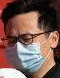

Helmet:  no
Mask:  yes
Image Width - Height: 60.0 78.0


In [5]:
sample_picker(dataset, sample_id = random.randint(0, len(dataset)))

# Exploratory Data Analysis

Length of dataset: 1792
Helmet Class distribution: {'yes': 1170, 'no': 622}
Mask Class distribution: {'yes': 494, 'no': 428, 'invisible': 869, 'wrong': 1}


Width DescribeResult(nobs=1792, minmax=(2.0, 1044.0), mean=31.303571428571427, variance=2503.673287070272, skewness=8.227933571175695, kurtosis=116.71127548341272) 

Height DescribeResult(nobs=1792, minmax=(2.0, 1012.0), mean=37.22377232142857, variance=3106.8594457281447, skewness=6.442690011010237, kurtosis=71.04713182089796) 

Ratio DescribeResult(nobs=1792, minmax=(0.5, 3.383177570093458), mean=1.1926839252653214, variance=0.06216621687743987, skewness=1.5830528358306917, kurtosis=9.701898175784155) 

Area DescribeResult(nobs=1792, minmax=(8.0, 1056528.0), mean=3879.4391741071427, variance=859915836.6127135, skewness=27.429987278127957, kurtosis=936.1386429873853) 



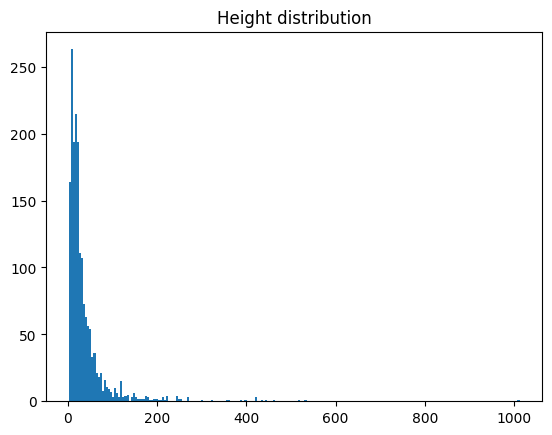

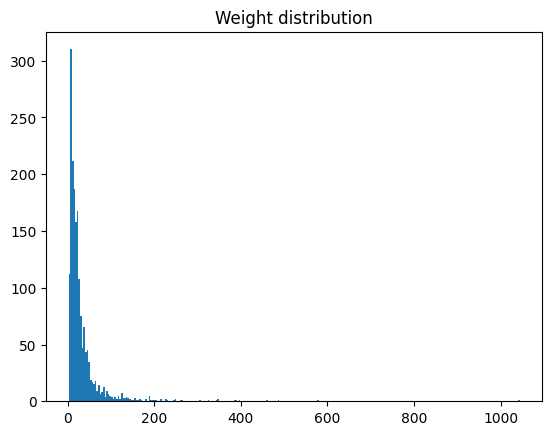

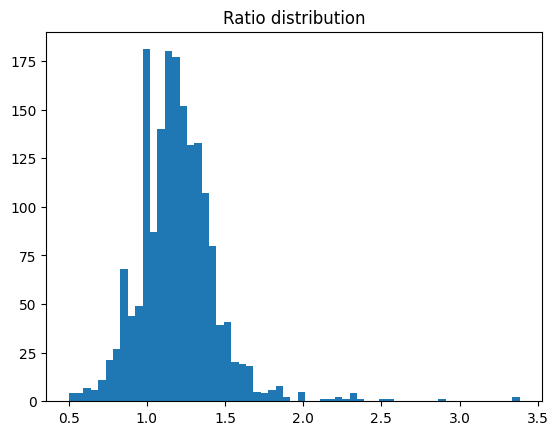

In [6]:
# Length of Dataset
print('Length of dataset: {}'.format(len(dataset)))

# Class distribution
helmet_stat = {}
mask_stat = {}
for data in dataset:
    helmet_stat[data.get('helmet_label', 'None')] = helmet_stat.get(data.get('helmet_label', 'None'), 0) + 1
    mask_stat[data.get('mask_label', 'None')] = mask_stat.get(data.get('mask_label', 'None'), 0) + 1
print('Helmet Class distribution:', helmet_stat)
print('Mask Class distribution:', mask_stat)
print('\n')

# Size distribution
width_list = ([data['width'] for data in dataset])
height_list = ([data['height'] for data in dataset])
hw_scale_list = ([data['height'] /data['width'] for data in dataset])
area_list = ([data['width'] * data['height'] for data in dataset])

print('Width', stats.describe(width_list), "\n")
print('Height', stats.describe(height_list), "\n")
print('Ratio', stats.describe(hw_scale_list), "\n")
print('Area', stats.describe(area_list), "\n")

import matplotlib.pyplot as plt

rng = np.array(height_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Height distribution")
plt.show()

rng = np.array(width_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Weight distribution")
plt.show()


rng = np.array(hw_scale_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Ratio distribution")
plt.show()

## Special Data
A single  label for "Wrong" Mask 

wrong


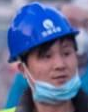

Helmet:  yes
Mask:  wrong
Image Width - Height: 88.0 112.0


In [7]:
special_data = []
for data in dataset:
    if data.get('mask_label', 'None') in [ 'wrong']:
        print(data.get('mask_label', 'None'))
        special_data.append(data)
        view_sample(data)


# Data split (Skip first, by overfit the dataset to prove working)

In [8]:
modes = ['train', 'val', 'test']

# For helmet data
PROCESSED_IMAGE_DIR = '..\dataset\processed\helmet'
for data in dataset:
        for mode in modes:
                directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['helmet_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])

# For mask data
PROCESSED_IMAGE_DIR = '..\dataset\processed\mask'
for data in dataset:
        for mode in modes:
                directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['mask_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])       

In [9]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),    #Too blurred image, remove the resized crop
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Helmet Model training (Resnet-18)
## Data Cleansing, Transformation, (and Augmentation)

In [36]:
data_dir = '../dataset/processed/helmet'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

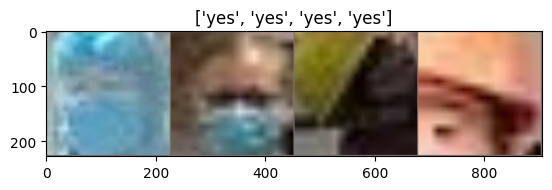

In [51]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model preparation part

In [54]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Transferring Learning from Resnet-18

In [40]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [41]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


C:\ProgramData\Anaconda3\envs\viact\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6520 Acc: 0.7109
val Loss: 0.4054 Acc: 0.8125

Epoch 1/24
----------
train Loss: 0.6046 Acc: 0.7467
val Loss: 0.3602 Acc: 0.8359

Epoch 2/24
----------
train Loss: 0.5800 Acc: 0.7600
val Loss: 0.3357 Acc: 0.8404

Epoch 3/24
----------
train Loss: 0.5415 Acc: 0.7907
val Loss: 0.2992 Acc: 0.8700

Epoch 4/24
----------
train Loss: 0.4509 Acc: 0.8069
val Loss: 0.2968 Acc: 0.8661

Epoch 5/24
----------
train Loss: 0.4318 Acc: 0.8209
val Loss: 0.3068 Acc: 0.8666

Epoch 6/24
----------
train Loss: 0.4713 Acc: 0.8108
val Loss: 0.2717 Acc: 0.8873

Epoch 7/24
----------
train Loss: 0.3010 Acc: 0.8828
val Loss: 0.2579 Acc: 0.8996

Epoch 8/24
----------
train Loss: 0.3109 Acc: 0.8700
val Loss: 0.2231 Acc: 0.9107

Epoch 9/24
----------
train Loss: 0.3135 Acc: 0.8778
val Loss: 0.2184 Acc: 0.9191

Epoch 10/24
----------
train Loss: 0.3089 Acc: 0.8750
val Loss: 0.2100 Acc: 0.9146

Epoch 11/24
----------
train Loss: 0.2922 Acc: 0.8917
val Loss: 0.2018 Acc: 0.9235

Epoch 12/24
----------
t

## Freeze the COV net layer

In [42]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6609 Acc: 0.6724
val Loss: 0.5262 Acc: 0.7584

Epoch 1/24
----------
train Loss: 0.6532 Acc: 0.7003
val Loss: 0.6033 Acc: 0.7227

Epoch 2/24
----------
train Loss: 0.6635 Acc: 0.7093
val Loss: 1.3981 Acc: 0.4665

Epoch 3/24
----------
train Loss: 0.6820 Acc: 0.7059
val Loss: 0.5238 Acc: 0.7818

Epoch 4/24
----------
train Loss: 0.6479 Acc: 0.7098
val Loss: 0.5215 Acc: 0.7517

Epoch 5/24
----------
train Loss: 0.6800 Acc: 0.7087
val Loss: 0.6898 Acc: 0.6931

Epoch 6/24
----------
train Loss: 0.6821 Acc: 0.7048
val Loss: 0.4539 Acc: 0.7963

Epoch 7/24
----------
train Loss: 0.5162 Acc: 0.7589
val Loss: 0.4439 Acc: 0.7935

Epoch 8/24
----------
train Loss: 0.5084 Acc: 0.7539
val Loss: 0.4373 Acc: 0.7997

Epoch 9/24
----------
train Loss: 0.4847 Acc: 0.7662
val Loss: 0.4666 Acc: 0.7824

Epoch 10/24
----------
train Loss: 0.5060 Acc: 0.7606
val Loss: 0.5256 Acc: 0.7355

Epoch 11/24
----------
train Loss: 0.4933 Acc: 0.7762
val Loss: 0.4185 Acc: 0.8153

Ep

# For Mask Model

In [11]:
data_dir = '../dataset/processed/mask'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

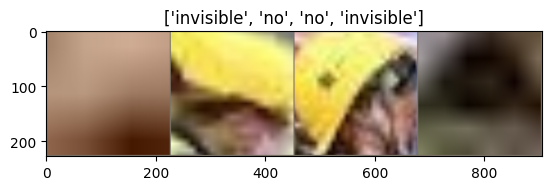

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


C:\ProgramData\Anaconda3\envs\viact\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.1624 Acc: 0.5385
val Loss: 0.8968 Acc: 0.6105

Epoch 1/24
----------
train Loss: 1.0449 Acc: 0.5893
val Loss: 0.8187 Acc: 0.6814

Epoch 2/24
----------
train Loss: 0.9429 Acc: 0.6161
val Loss: 0.8044 Acc: 0.7288

Epoch 3/24
----------
train Loss: 0.8689 Acc: 0.6551
val Loss: 0.6329 Acc: 0.7645

Epoch 4/24
----------
train Loss: 0.8770 Acc: 0.6535
val Loss: 0.5867 Acc: 0.7907

Epoch 5/24
----------
train Loss: 0.8177 Acc: 0.6713
val Loss: 0.5762 Acc: 0.7891

Epoch 6/24
----------
train Loss: 0.6979 Acc: 0.7310
val Loss: 0.5693 Acc: 0.7773

Epoch 7/24
----------
train Loss: 0.5994 Acc: 0.7729
val Loss: 0.4310 Acc: 0.8482

Epoch 8/24
----------
train Loss: 0.5500 Acc: 0.8019
val Loss: 0.4171 Acc: 0.8404

Epoch 9/24
----------
train Loss: 0.5265 Acc: 0.8086
val Loss: 0.3781 Acc: 0.8655

Epoch 10/24
----------
train Loss: 0.5216 Acc: 0.8019
val Loss: 0.3795 Acc: 0.8694

Epoch 11/24
----------
train Loss: 0.5143 Acc: 0.8030
val Loss: 0.3521 Acc: 0.8767

Epoch 12/24
----------
t

In [19]:
MODEL_OUTPUT_PATH = '..\output'
torch.save(model_ft.state_dict(), os.path.join(MODEL_OUTPUT_PATH, 'mask_resnet'))

# Train Custom Data for YOLO V5
## https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data